In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.prepared import prep
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



ERROR 1: PROJ: proj_create_from_database: Open of /home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/share/proj failed


In [2]:

# Load the Philippine waters shapefile
phil_waters = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/waters/philippine_waters_filled.shp")

ph_shape = phil_waters.geometry.iloc[0]
ph_buffered = ph_shape.buffer(0.5)  # 0.5 degrees (since CRS is EPSG:4326)

In [3]:
par_coords = [
    (120, 25),
    (135, 25),
    (135, 5),
    (115, 5),
    (115, 15),
    (120, 21),
    (120, 25)  # Close the polygon
]

# Create PAR polygon
par_poly = Polygon(par_coords)
par_gdf = gpd.GeoDataFrame(geometry=[par_poly], crs="EPSG:4326")

In [4]:
# Load the IBTrACS data CSV
ibtracs = pd.read_csv("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
ibtracs = ibtracs[ibtracs.SEASON>=1979]
# Step 2: Get unique storm IDs
unique_sids = ibtracs["SID"].unique()

In [5]:
len(unique_sids)

1507

In [6]:
# Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs,
    geometry=gpd.points_from_xy(ibtracs["LON"], ibtracs["LAT"]),
    crs="EPSG:4326"
)

In [7]:
from shapely.geometry import LineString
from shapely.prepared import prep

# Prepare the PH and PAR polygons
ph_prepared = prep(ph_buffered)
par_prepared = prep(par_poly)

# Also get their bounding boxes for a fast first filter
ph_bounds = ph_buffered.bounds
par_bounds = par_poly.bounds

intersect_results = []

for sid, group in gdf_tracks.groupby("SID"):
    points = list(group.sort_values("ISO_TIME")["geometry"])
    if len(points) < 2:
        continue  # Skip storms with insufficient points

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Fast bounding box skip
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

    # Use prepped geometry for faster intersects
    intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_par = False if skip_par else par_prepared.intersects(track_line)

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par
    })

# Wrap in DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Final counts
n_track_in_ph = df_intersects["intersects_ph"].sum()
n_track_in_par = df_intersects["intersects_par"].sum()

print(f"{n_track_in_ph} TCs intersected PH buffer.")
print(f"{n_track_in_par} TCs intersected PAR.")


461 TCs intersected PH buffer.
957 TCs intersected PAR.


In [8]:
# Step 1: Get SIDs that intersect PH and PAR
sids_ph = df_intersects[df_intersects["intersects_ph"]]["SID"]
sids_par = df_intersects[df_intersects["intersects_par"]]["SID"]

# Step 2: Count number of 3-hourly points within each region

# For PH
ph_lifetime = (
    gdf_tracks[gdf_tracks["SID"].isin(sids_ph)]
    .groupby("SID")
    .size()
    .reset_index(name="n_points")
)
ph_lifetime["hours_total_ph"] = ph_lifetime["n_points"] * 3

# For PAR
par_lifetime = (
    gdf_tracks[gdf_tracks["SID"].isin(sids_par)]
    .groupby("SID")
    .size()
    .reset_index(name="n_points")
)
par_lifetime["hours_total_par"] = par_lifetime["n_points"] * 3

# Step 3: Compute average
avg_total_ph_hours = ph_lifetime["hours_total_ph"].mean()
avg_total_par_hours = par_lifetime["hours_total_par"].mean()

print(f"Average lifetime of TCs intersecting Ph (for {len(ph_lifetime)} storms): {avg_total_ph_hours:.1f} hours")
print(f"Average lifetime of TCs intersecting PAR (for {len(par_lifetime)} storms): {avg_total_par_hours:.1f} hours")


Average lifetime of TCs intersecting Ph (for 461 storms): 215.6 hours
Average lifetime of TCs intersecting PAR (for 957 storms): 225.7 hours


In [9]:
# Filter points inside PH buffer
ph_inside = gdf_tracks[
    (gdf_tracks["SID"].isin(sids_ph)) & 
    (gdf_tracks.geometry.within(ph_buffered))
]

# Count points per SID
ph_lf_lifetime = (
    ph_inside.groupby("SID")
    .size()
    .reset_index(name="n_points")
)
ph_lf_lifetime["hours_inside_ph"] = ph_lf_lifetime["n_points"] * 3

# Compute average lifetime inside PH
avg_ph_hours = ph_lf_lifetime["hours_inside_ph"].mean()
print(f"Average TC lifetime *inside PH buffer*: {avg_ph_hours:.1f} hours (based on {len(ph_lf_lifetime)} storms)")


Average TC lifetime *inside PH buffer*: 27.8 hours (based on 460 storms)


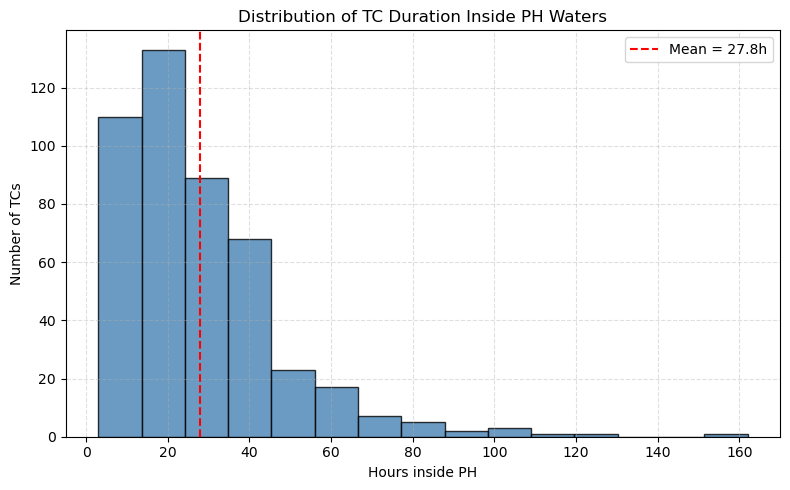

In [110]:
plt.figure(figsize=(8, 5))
plt.hist(ph_lf_lifetime["hours_inside_ph"], bins=15, color='steelblue', edgecolor='black', alpha=0.8)

plt.title("Distribution of TC Duration Inside PH Waters")
plt.xlabel("Hours inside PH")
plt.ylabel("Number of TCs")
plt.grid(True, linestyle='--', alpha=0.4)

# Optional: mark mean
mean_duration = ph_lf_lifetime["hours_inside_ph"].mean()
plt.axvline(mean_duration, color='red', linestyle='--', label=f"Mean = {mean_duration:.1f}h")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Filter points inside PAR
par_inside = gdf_tracks[
    (gdf_tracks["SID"].isin(sids_par)) & 
    (gdf_tracks.geometry.within(par_poly))
]

# Count points per SID
par_enter_lifetime = (
    par_inside.groupby("SID")
    .size()
    .reset_index(name="n_points")
)
par_enter_lifetime["hours_inside_par"] = par_enter_lifetime["n_points"] * 3

# Compute average lifetime inside PAR
avg_par_hours = par_enter_lifetime["hours_inside_par"].mean()
print(f"Average TC lifetime *inside PAR*: {avg_par_hours:.1f} hours (based on {len(par_enter_lifetime)} storms)")


Average TC lifetime *inside PAR*: 85.4 hours (based on 946 storms)


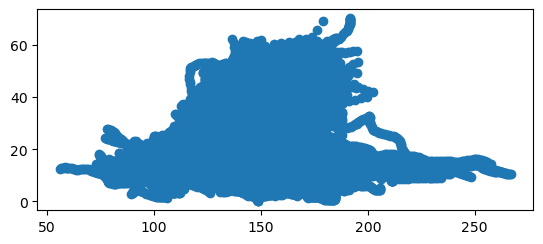

In [11]:
gdf_tracks.plot()
plt.show()

In [12]:
landfall_sids = df_intersects[df_intersects.intersects_ph]['SID'].unique()
len(landfall_sids)

461

In [13]:
df_intersects

,SID,intersects_ph,intersects_par
0,1978361N02180,False,True
1,1979077N07150,False,True
2,1979098N02144,True,True
3,1979126N04148,True,True
4,1979137N19116,False,True
...,...,...,...
1501,2024308N10138,True,True
1502,2024314N14132,True,True
1503,2024314N14160,True,True
1504,2024316N12139,True,True


In [14]:
# Initialize the new columns
gdf_tracks['intersects_ph'] = False
gdf_tracks['intersects_par'] = False

# Filter SIDs from df_intersects where intersections occurred
ph_sids = df_intersects[df_intersects['intersects_ph'] == True]['SID']
par_sids = df_intersects[df_intersects['intersects_par'] == True]['SID']

# Update gdf_tracks based on SIDs
gdf_tracks.loc[gdf_tracks['SID'].isin(ph_sids), 'intersects_ph'] = True
gdf_tracks.loc[gdf_tracks['SID'].isin(par_sids), 'intersects_par'] = True
gdf_lf = gdf_tracks[gdf_tracks['intersects_ph']].copy().reset_index(drop=True)

In [35]:
import numpy as np

In [100]:
def label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME'):
    df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
    df_sid['phase'] = 'outside'
    df_sid['t_hours'] = np.nan

    entry_idx = None
    exit_idx = None

    # Generate segment lines and check for intersection
    for i in range(len(df_sid) - 1):
        p1 = df_sid.at[i, 'geometry']
        p2 = df_sid.at[i + 1, 'geometry']
        segment = LineString([p1, p2])

        if ph_prepared.intersects(segment):
            if entry_idx is None:
                entry_idx = i  # First intersecting segment
            exit_idx = i + 1  # Keep updating until last intersecting segment

    if entry_idx is None or exit_idx is None:
        return df_sid  # No intersection; skip labeling

    # Time reference point = first entry
    t_entry = df_sid.at[entry_idx, time_col]

    # Label phases and compute t_hours
    for i in range(len(df_sid)):
        current_time = df_sid.at[i, time_col]
        t_diff = (current_time - t_entry).total_seconds() / 3600

        if i < entry_idx:
            df_sid.at[i, 'phase'] = 'approach'
            df_sid.at[i, 't_hours'] = t_diff
        elif entry_idx <= i <= exit_idx:
            df_sid.at[i, 'phase'] = 'within'
            df_sid.at[i, 't_hours'] = t_diff
        elif i > exit_idx:
            df_sid.at[i, 'phase'] = 'departure'
            df_sid.at[i, 't_hours'] = t_diff

    return df_sid

def label_and_interpolate_tc(
    gdf_lf, 
    ph_mask_col='intersects_ph', 
    wind_col='WMO_WIND', 
    time_col='ISO_TIME', 
    dir_col='STORM_DIR',
    max_hours=48,
    filter_westward=True,
    verbose=False
):
    """
    Labels TC points as 'approach', 'within', or 'departure' and interpolates WMO_WIND.
    Optionally filters westward-moving TCs and handles string direction values.
    """
    processed = []

    # for sid in gdf_lf['SID'].unique():
    for sid in tqdm(gdf_lf['SID'].unique(), desc="Processing TCs"):

        df_sid = gdf_lf[gdf_lf['SID'] == sid].copy()
        df_sid = df_sid.sort_values(time_col).reset_index(drop=True)
        df_sid[time_col] = pd.to_datetime(df_sid[time_col]) 

        # Force numeric STORM_DIR (errors='coerce' sets invalid to NaN)
        df_sid[dir_col] = pd.to_numeric(df_sid[dir_col], errors='coerce')

        # Optional: filter out non-westward TCs
        if filter_westward:
            valid_dirs = df_sid[dir_col].dropna()
            if valid_dirs.empty or not ((valid_dirs > 180) & (valid_dirs < 360)).any():
                if verbose:
                    print(f"Skipping SID {sid}: no valid westward direction")
                continue

        # Skip if no intersecting points
        if not df_sid[ph_mask_col].any():
            if verbose:
                print(f"Skipping SID {sid}: no intersection")
            continue

        df_sid = label_tc_by_segment_intersection(df_sid, ph_prepared, time_col='ISO_TIME')

        
        # Interpolation
        in_window = df_sid['phase'].isin(['approach', 'within', 'departure'])
        df_sid['WMO_WIND_interp'] = np.nan

        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = df_sid.loc[in_window, wind_col].interpolate(method='linear')

        # Clean and convert wind to float
        df_sid[wind_col] = pd.to_numeric(df_sid[wind_col], errors='coerce')
        
        # # Interpolate only if enough valid values
        # if df_sid.loc[in_window, wind_col].notna().sum() >= 2:
        #     df_sid.loc[in_window, 'WMO_WIND_interp'] = (
        #         df_sid.loc[in_window, wind_col]
        #         .interpolate(method='linear')
        #         .astype(float)  # Ensure it's float for assignment
        #     )

        # Interpolate only if enough valid values
        wind_series = df_sid.loc[in_window, wind_col]
        
        if wind_series.notna().sum() >= 2:
            interpolated = wind_series.interpolate(method='linear')
        
            # Mask out extrapolated values
            first_valid = wind_series.first_valid_index()
            last_valid = wind_series.last_valid_index()
        
            # interpolated.loc[:first_valid] = np.nan
            # interpolated.loc[last_valid+1:] = np.nan
        
            first_pos = wind_series.index.get_loc(first_valid)
            last_pos = wind_series.index.get_loc(last_valid)
            
            # Mask *before* first and *after* last (but not the valid points themselves)
            interpolated.iloc[:first_pos] = np.nan
            interpolated.iloc[last_pos+1:] = np.nan

            
            df_sid.loc[in_window, 'WMO_WIND_interp'] = interpolated.astype(float)

        
        processed.append(df_sid)

    df_out = pd.concat(processed, ignore_index=True)
    return df_out


In [101]:
df_ph_labeled = label_and_interpolate_tc(gdf_lf, filter_westward=True, verbose=True)


Processing TCs:   0%|          | 0/461 [00:00<?, ?it/s]

Skipping SID 1994197N14115: no valid westward direction
Skipping SID 1996137N13111: no valid westward direction
Skipping SID 1996356N08110: no valid westward direction
Skipping SID 1997143N17111: no valid westward direction
Skipping SID 2000138N16119: no valid westward direction
Skipping SID 2000141N18116: no valid westward direction
Skipping SID 2014160N21120: no valid westward direction
Skipping SID 2017291N09116: no valid westward direction


In [102]:

# Create a copy just in case
df_plot = df_ph_labeled.copy()

# Round t_hours to nearest 3-hour step
df_plot['t_rounded'] = df_plot['t_hours'].round()

# Filter to relevant range (±48 hours)
df_plot = df_plot[df_plot['t_rounded'].between(-48, 48)]


In [104]:
df_plot.t_hours.max()

48.0

In [105]:
def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

grouped = df_plot.groupby('t_rounded')['WMO_WIND_interp']
stats_df = grouped.agg(
    mean='mean',
    median='median',
    count='count',
    p25=lambda x: safe_percentile(x, 25),
    p75=lambda x: safe_percentile(x, 75)
).reset_index()


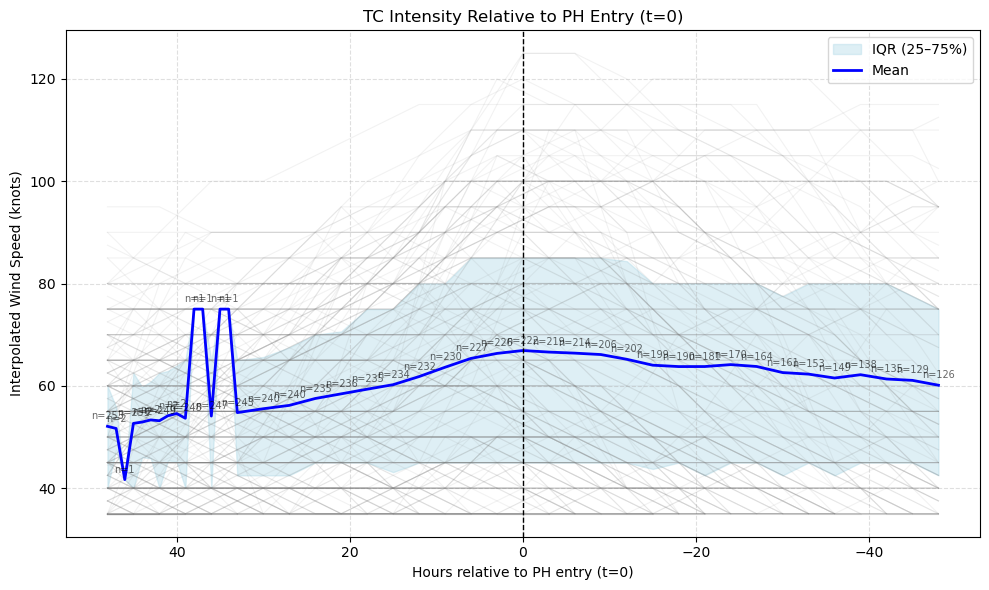

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))

# Faint individual TC lines
for sid, group in df_plot.groupby('SID'):
    ax.plot(group['t_rounded'], group['WMO_WIND_interp'], 
            color='gray', alpha=0.1, linewidth=0.8)

# IQR band
ax.fill_between(stats_df['t_rounded'], stats_df['p25'], stats_df['p75'],
                color='lightblue', alpha=0.4, label='IQR (25–75%)')

# Mean line
ax.plot(stats_df['t_rounded'], stats_df['mean'], color='blue', linewidth=2, label='Mean')

# Vertical line at t=0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Add count labels every 3-hour point
for i, row in stats_df.iterrows():
    ax.annotate(f"n={int(row['count'])}", 
                (row['t_rounded'], row['mean']), 
                textcoords="offset points", xytext=(0, 5),
                ha='center', fontsize=7, alpha=0.6)

# Reverse X-axis: Approach → right; Departure → left
ax.invert_xaxis()

# Labels and grid
ax.set_title('TC Intensity Relative to PH Entry (t=0)')
ax.set_xlabel('Hours relative to PH entry (t=0)')
ax.set_ylabel('Interpolated Wind Speed (knots)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Split the data into phases
df_approach = df_ph_labeled[df_ph_labeled['phase'] == 'approach'].copy()
df_within = df_ph_labeled[df_ph_labeled['phase'] == 'within'].copy()
df_departure = df_ph_labeled[df_ph_labeled['phase'] == 'departure'].copy()

# Step 2: Round t_hours to nearest 3h step
for df in [df_approach, df_within, df_departure]:
    df['t_step'] = df['t_hours'].round()

# Approach: keep only t_step from -48 to 0
df_approach = df_approach[df_approach['t_step'].between(-48, 0)]

# Departure: keep only t_step from 0 to +48
df_departure = df_departure[df_departure['t_step'].between(0, 48)]

# Within already truncated
df_within = df_within[df_within['t_step'] <= 48]


def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan


# Step 4: Stats computation function
def compute_stats(df):
    grouped = df.groupby('t_step')['WMO_WIND_interp']
    return grouped.agg(
        mean='mean',
        p25=lambda x: safe_percentile(x, 25),
        p75=lambda x: safe_percentile(x, 75)
    ).reset_index()


# Step 5: Compute stats for each phase
stats_approach = compute_stats(df_approach)
stats_within = compute_stats(df_within)
stats_departure = compute_stats(df_departure)




In [120]:
def plot_phase(ax, df, stats, title, x_reverse=False, x_flip_labels=False):
    for sid, group in df.groupby('SID'):
        ax.plot(group['t_step'], group['WMO_WIND_interp'], color='gray', alpha=0.1)

    ax.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='lightblue', alpha=0.4, label='IQR (25–75%)')
    ax.plot(stats['t_step'], stats['mean'], color='blue', linewidth=2, label='Mean')

    if x_reverse:
        ax.set_xlim(ax.get_xlim()[::-1])  # Flip x-axis direction (but keep axis labels intact)

    if x_flip_labels:
        from matplotlib.ticker import FixedLocator
        
        ticks = ax.get_xticks()
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.set_xticklabels([int(-1 * t) for t in ticks])


    ax.set_title(title)
    ax.set_xlabel('Relative time (hours)')
    ax.grid(True, linestyle='--', alpha=0.3)


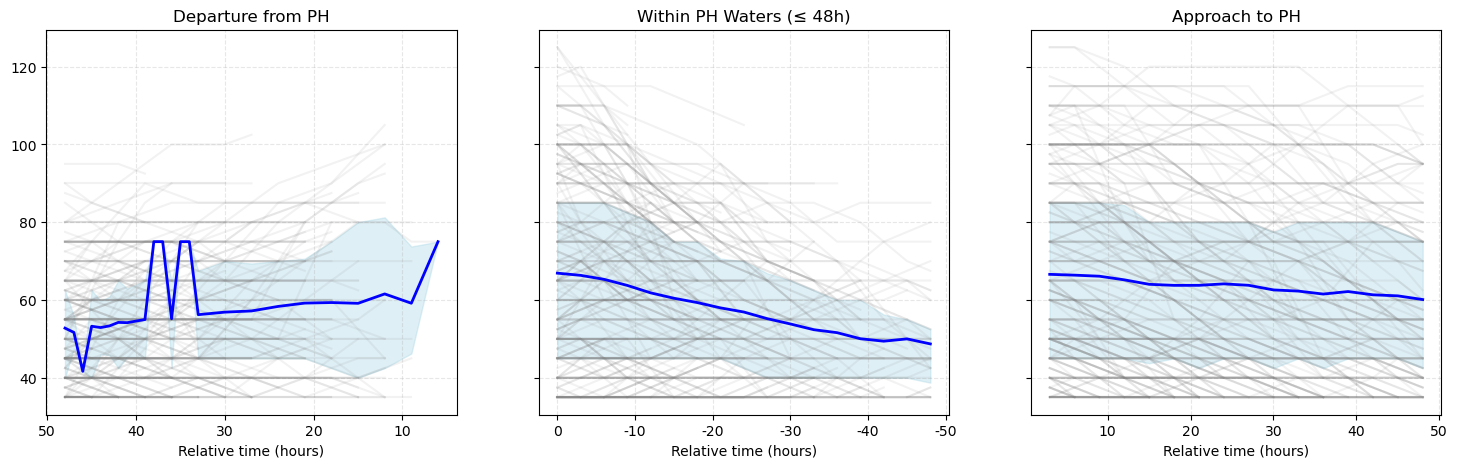

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# LEFT: Departure (positive → 0)
plot_phase(axs[0], df_departure, stats_departure, "Departure from PH",
           x_reverse=True, x_flip_labels=False)

# CENTER: Within (0 → +48)
plot_phase(axs[1], df_within, stats_within, "Within PH Waters (≤ 48h)",
           x_reverse=False, x_flip_labels=True)

# RIGHT: Approach (0 → -48 shown as -48 to 0 left to right)
plot_phase(axs[2], df_approach, stats_approach, "Approach to PH",
           x_reverse=True, x_flip_labels=True)


In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Round t_hours
df_plot = df_ph_labeled.copy()
df_plot['t_step'] = df_plot['t_hours'].round()

# Optional: Limit to ±72h
df_plot = df_plot[df_plot['t_step'].between(-72, 72)]

# Step 2: Safe stats
def safe_percentile(x, q):
    x_clean = x.dropna()
    return np.percentile(x_clean, q) if len(x_clean) > 0 else np.nan

def compute_stats(df):
    grouped = df.groupby('t_step')['WMO_WIND_interp']
    return grouped.agg(
        median='median',
        count='count',
        p25=lambda x: safe_percentile(x, 25),
        p75=lambda x: safe_percentile(x, 75)
    ).reset_index()

stats = compute_stats(df_plot)

stats = stats[stats['count'] >= 5]


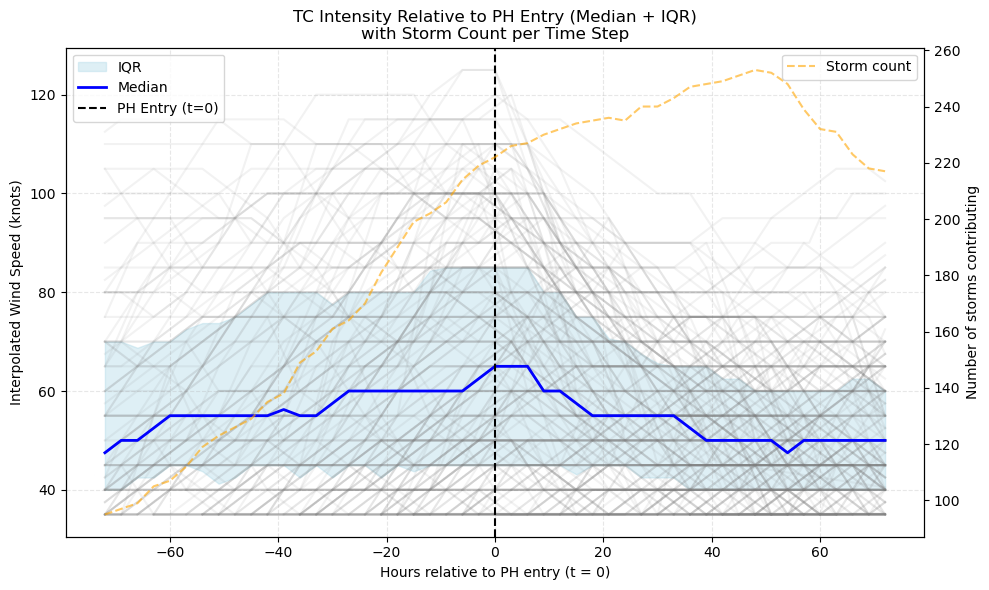

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Main intensity plot
for sid, group in df_plot.groupby('SID'):
    ax1.plot(group['t_step'], group['WMO_WIND_interp'], color='gray', alpha=0.1)

ax1.fill_between(stats['t_step'], stats['p25'], stats['p75'], color='lightblue', alpha=0.4, label='IQR')
ax1.plot(stats['t_step'], stats['median'], color='blue', linewidth=2, label='Median')
ax1.axvline(0, color='black', linestyle='--', label='PH Entry (t=0)')
ax1.set_xlabel("Hours relative to PH entry (t = 0)")
ax1.set_ylabel("Interpolated Wind Speed (knots)")
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(loc='upper left')

# Secondary axis for storm count
ax2 = ax1.twinx()
ax2.plot(stats['t_step'], stats['count'], color='orange', alpha=0.6, linestyle='--', label='Storm count')
ax2.set_ylabel("Number of storms contributing")
ax2.legend(loc='upper right')

plt.title("TC Intensity Relative to PH Entry (Median + IQR)\nwith Storm Count per Time Step")
plt.tight_layout()
plt.show()
